
# **Linear Regression Lab Notebook**

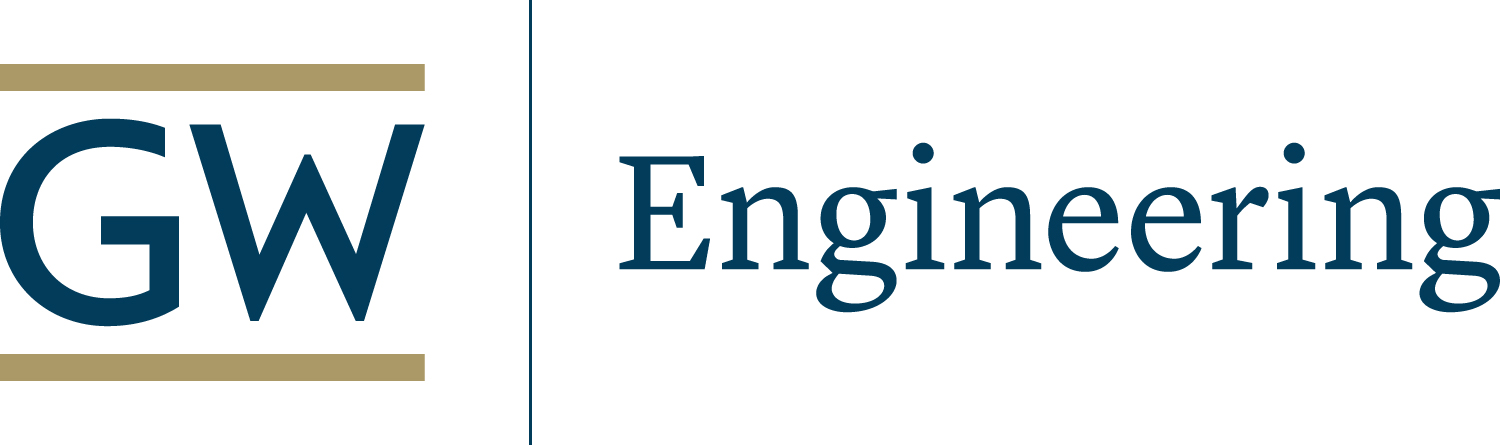

In [2]:
#Need to install this as Colab does not have it installed yet...
# %pip install cartopy
# %pip install pandas
# %pip install numpy
# % pip install matplotlib
# % pip install seaborn
# % pip install scikit-learn
# % pip install statsmodels

import warnings
warnings.filterwarnings("ignore")

Cartopy is a Python package designed to make drawing maps for data analysis and visualisation easy.


In [3]:
#Loading Libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for map projection
import cartopy.feature as cfeature # for adding features to the map
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # for splitting the dataset into training and testing sets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # for model evaluation
from sklearn.preprocessing import LabelEncoder # convert categorical variables to numerical

california_housing_data*.csv is California housing data from the 1990 US Census; more information is available at: https://developers.google.com/machine-learning/crash-course/california-housing-data-description

In [4]:
#Loading CSV into a Dataframe
df_cal = pd.read_csv('..\data\california_housing_train.csv') #relative path to the CSV file
df_cal.head() #display the first 5 rows of the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Lets use Matplotlib to explore the data.  Lat/Lon seems interesting.  Can we associate those datapoints with another features that shows a pattern?

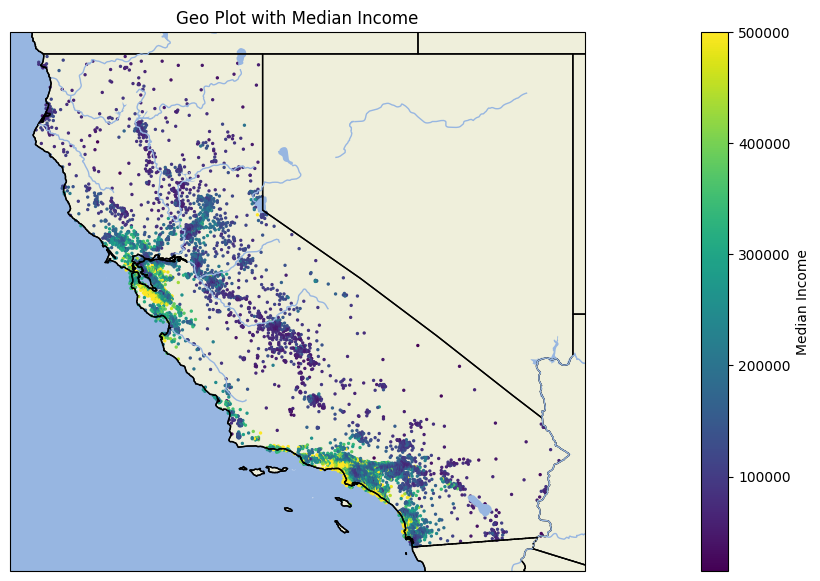

In [5]:
fig = plt.figure(figsize=(15, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS, linestyle=':')

scatter = ax.scatter(df_cal['longitude'], df_cal['latitude'], s=2, transform=ccrs.PlateCarree(), c=df_cal['median_house_value'], cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)

cbar.set_label('Median Income')

plt.title('Geo Plot with Median Income')

plt.show()


### ***Simple Linear Regression***

In [58]:
# Linear Regression Example
'''
This demonstrates how to perform linear regression using the `scikit-learn` library.
'''

# Generate a sample dataset
np.random.seed(0)
X = 2 * np.random.rand(1000, 1)  # 100 samples, 1 feature
y = 4 + 3 * X + np.random.randn(1000, 1)  # Linear relation with some noise


In [59]:
X

array([[1.09762701e+00],
       [1.43037873e+00],
       [1.20552675e+00],
       [1.08976637e+00],
       [8.47309599e-01],
       [1.29178823e+00],
       [8.75174423e-01],
       [1.78354600e+00],
       [1.92732552e+00],
       [7.66883038e-01],
       [1.58345008e+00],
       [1.05778984e+00],
       [1.13608912e+00],
       [1.85119328e+00],
       [1.42072116e-01],
       [1.74258599e-01],
       [4.04367949e-02],
       [1.66523969e+00],
       [1.55631350e+00],
       [1.74002430e+00],
       [1.95723668e+00],
       [1.59831713e+00],
       [9.22958725e-01],
       [1.56105835e+00],
       [2.36548852e-01],
       [1.27984204e+00],
       [2.86706575e-01],
       [1.88933783e+00],
       [1.04369664e+00],
       [8.29323880e-01],
       [5.29111224e-01],
       [1.54846738e+00],
       [9.12300664e-01],
       [1.13686790e+00],
       [3.75796009e-02],
       [1.23527099e+00],
       [1.22419145e+00],
       [1.23386799e+00],
       [1.88749616e+00],
       [1.36364060e+00],


In [60]:
y

array([[ 7.19118375],
       [ 8.31041558],
       [ 9.4661715 ],
       [ 7.05513244],
       [ 6.04291216],
       [ 7.8967159 ],
       [ 5.70640982],
       [ 9.54339185],
       [ 9.41692135],
       [ 4.50932156],
       [ 8.69176368],
       [ 6.85582642],
       [ 5.77584406],
       [ 9.48644568],
       [ 5.91557231],
       [ 5.04407955],
       [ 4.73323758],
       [ 7.65422235],
       [ 9.14583887],
       [ 9.36852247],
       [10.40075529],
       [ 9.21758001],
       [ 5.40909545],
       [ 8.64177425],
       [ 3.95177569],
       [ 7.78944203],
       [ 3.9627188 ],
       [10.98048387],
       [ 6.27211754],
       [ 5.58902948],
       [ 5.66192008],
       [ 7.56830307],
       [ 6.31223869],
       [ 6.5806391 ],
       [ 5.52391087],
       [ 8.49161681],
       [ 7.61510482],
       [ 7.31038693],
       [10.60340609],
       [ 8.49612587],
       [ 6.65509981],
       [ 6.59599949],
       [ 6.49755715],
       [ 4.24888685],
       [ 7.46811037],
       [ 8

Text(0.5, 0, 'X')

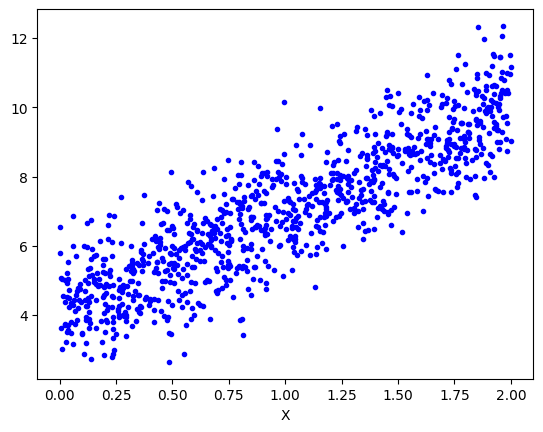

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("X")

In [63]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), y_train)

# Predict on the test set
y_pred = model.predict(X_test)


Mean Squared Error: 0.78
R^2 Score: 0.80
Coefficients:  [[2.91292259]]
Intercept:  [4.1058555]


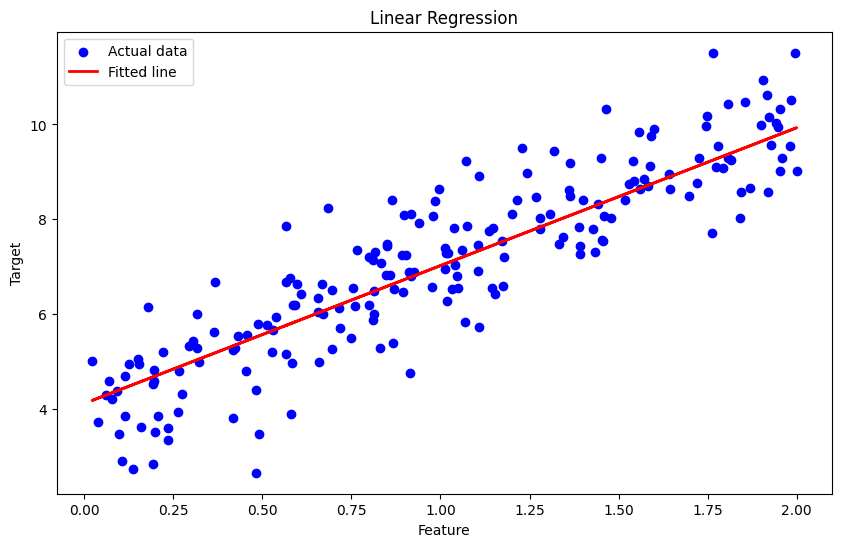

In [64]:

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) # R-squared score.  It indicates how well the model explains the variance in the data.
coefficients = model.coef_
intercept = model.intercept_

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print("Coefficients: ", coefficients)
print("Intercept: ", intercept)


# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Fitted line')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.legend()
plt.show()


### **Linear Regression with the Housing Data**

In [11]:
X = df_cal[['median_income']] # notice we need to have a 2d structure - hence [[]]
y = df_cal['median_house_value']

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Mean Squared Error: 6908440691.53
Mean Absolute Error: 62617.00
R^2 Score: 0.49


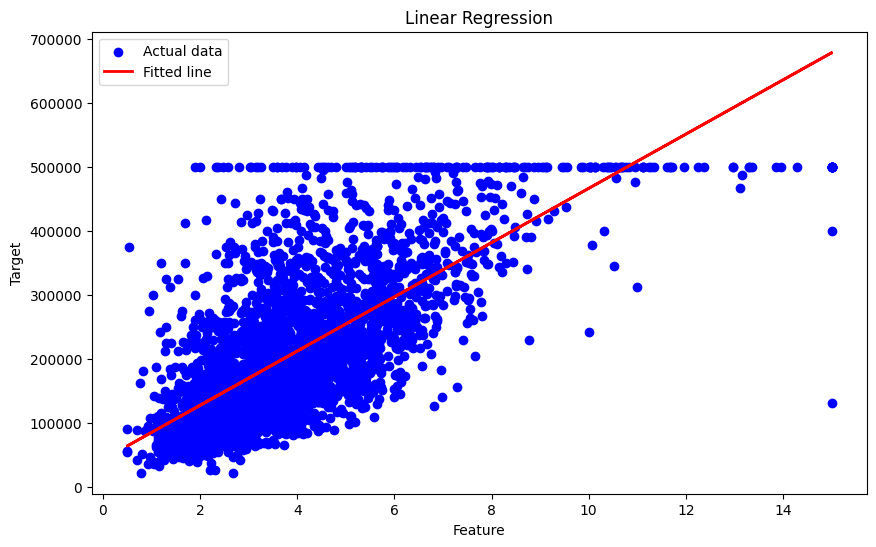

In [13]:
# Initialize and fit the linear regression model
model = LinearRegression()
trained_model = model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Fitted line')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [14]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Get model parameters
coefficients = model.coef_
intercept = model.intercept_

# Print summary
print("Model Performance Summary:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Model Performance Summary:
Mean Squared Error (MSE): 6908440691.53
R-squared (R²): 0.49
Mean Absolute Error (MAE): 62617.00
Model Coefficients: [42357.10585794]
Intercept: 42950.02905942401


The limitation is basically not all metrics are readily availailable and you may beed to compute them.  For example, there isnt a easy way to get SE from scikitlearn.  Recall, SE is the estimate in regression analysis measures the average distance that the observed values fall from the predicted values (the regression line). It provides a way to quantify the precision of the predictions made by the regression model  To get it, use something like this:

Some more metrics you can find outside of scikitlearn

OLS in StatsModel

In [15]:
X_test['ones'] = 1 # add a column of ones for the intercept term
X_train['ones'] = 1 # add a column of ones for the intercept term


In [16]:
X_test

,median_income,ones
7263,1.5429,1
4211,4.7245,1
1392,3.8194,1
13157,2.1714,1
10393,4.4519,1
...,...,...
2397,5.6973,1
7235,6.5861,1
13368,5.1104,1
9586,2.9844,1


In [17]:
model1 = sm.OLS(y_test, X_test) # Ordinary Least Squares regression.  Instantiate the model
fitted_model = model1.fit() # Training means fitting the model to the training data

In [18]:
y_pred1 = fitted_model.predict(X_test) # Predicting the target variable using the fitted model

In [19]:
# Here is where we can see the predictions.  Just a set of numbers to compare against actual test values
y_pred1

7263     110901.902755
4211     241207.825932
1392     204138.461126
13157    136642.810700
10393    230043.193464
             ...      
2397     281049.918610
7235     317451.699010
13368    257012.784366
9586     169940.118829
15084    220709.298603
Length: 3400, dtype: float64

In [20]:
y_test

7263     325000.0
4211     273600.0
1392      98500.0
13157    190600.0
10393    227900.0
           ...   
2397     164800.0
7235     417800.0
13368    278100.0
9586     132000.0
15084    349600.0
Name: median_house_value, Length: 3400, dtype: float64

MEAN ABSOLUTE ERROR!!

In [65]:
error_for_test = y_test - y_pred # Calculate the errors for the test set
error_for_test_abs = np.abs(error_for_test) # Calculate the absolute error for the test set
#This is the Mean Absolute Error (MAE) for the test set
error_for_test_abs.mean()

np.float64(0.6817035186100169)

MSE Mean Squared Error!!

In [66]:
error_for_test_squared = error_for_test ** 2 # Square the errors
#This is the MSE - Mean Squared Error!!
error_for_test_squared.mean() # Mean of the squared errors

np.float64(0.7778979446150527)

RMSE Root Mean Squared Error!!

In [67]:
rmse = np.sqrt(error_for_test_squared.mean())
#This is the RMSE - Root Mean Squared Error!!
print(rmse) # Mean of the squared errors

0.8819852292499306


In [68]:
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     3237.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:58:50   Log-Likelihood:                -43338.
No. Observations:                3400   AIC:                         8.668e+04
Df Residuals:                    3398   BIC:                         8.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
median_income  4.096e+04    719.881     56.893

In [69]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

RMSE: 0.8819852292499306
MAE: 0.6817035186100169


OK So how might we ID an outlier...

In [71]:
# Standardize the errors
standardized_errors = (error_for_test - error_for_test.mean()) / error_for_test.std()

# Add the standardized errors as a new column to the dataframe
# error_for_test_df = pd.DataFrame({'Error': error_for_test, 'Standardized_Error': standardized_errors})

# error_for_test_df.head()  # Display the first few rows

In [ ]:
# These may be outliers that we want to investigate further.
# outliers = error_for_test_df[error_for_test_df['Standardized_Error'].abs() > 4]
outliers = standardized_errors > 4 # Identify the outliers based on standardized errors
outliers

AttributeError: 'numpy.ndarray' object has no attribute 'np'

In [54]:
from scipy.stats import shapiro, kstest

# Perform Shapiro-Wilk test
shapiro_test_stat, shapiro_p_value = shapiro(error_for_test)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")

# Perform Kolmogorov-Smirnov test
ks_test_stat, ks_p_value = kstest(error_for_test, 'norm', args=(error_for_test.mean(), error_for_test.std()))
print(f"Kolmogorov-Smirnov Test Statistic: {ks_test_stat:.4f}, p-value: {ks_p_value:.4f}")

Shapiro-Wilk Test Statistic: 0.9496, p-value: 0.3611


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [38]:
log_data = np.log1p(error_for_test)  # or np.log1p(data) if data has zeros

In [36]:
# Perform Shapiro-Wilk test
shapiro_test_stat, shapiro_p_value = shapiro(log_data)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")

# Perform Kolmogorov-Smirnov test
ks_test_stat, ks_p_value = kstest(log_data, 'norm', args=(error_for_test.mean(), error_for_test.std()))
print(f"Kolmogorov-Smirnov Test Stati   stic: {ks_test_stat:.4f}, p-value: {ks_p_value:.4f}")

Shapiro-Wilk Test Statistic: nan, p-value: nan
Kolmogorov-Smirnov Test Stati   stic: nan, p-value: nan


In [39]:
log_data

7263     12.274194
4211     10.385703
1392           NaN
13157    10.895965
10393          NaN
           ...    
2397           NaN
7235     11.516412
13368     9.956470
9586           NaN
15084    11.766728
Length: 3400, dtype: float64

(array([1., 2., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 2., 2., 0., 0., 0.,
        0., 0., 0., 3., 0., 1., 0., 0., 1., 0., 0., 0., 2.]),
 array([-1.46783474, -1.36174695, -1.25565916, -1.14957138, -1.04348359,
        -0.9373958 , -0.83130802, -0.72522023, -0.61913244, -0.51304465,
        -0.40695687, -0.30086908, -0.19478129, -0.0886935 ,  0.01739428,
         0.12348207,  0.22956986,  0.33565764,  0.44174543,  0.54783322,
         0.65392101,  0.76000879,  0.86609658,  0.97218437,  1.07827216,
         1.18435994,  1.29044773,  1.39653552,  1.50262331,  1.60871109,
         1.71479888]),
 <BarContainer object of 30 artists>)

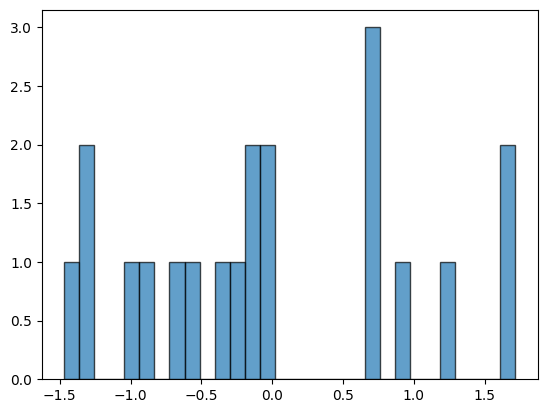

In [56]:
plt.hist(error_for_test, bins=30, edgecolor='k', alpha=0.7)